In [2]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D

from cryptic_rnn import *

# Functions

## RNN params

In [3]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1800
num_sims = 200

## Sequences

In [20]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

print('trainseqs ',trainseqs)
print('trainseqs_b ',trainseqs_b)
print('trainseqs_p ',trainseqs_p)
print('trainseqs_bp ',trainseqs_bp)

testseqs = generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 2) 
testseqs3 = generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 3) 

#+generate_neg_trials('-', all_syms, all_syms, cue_dict, steps = 2)

print('testseqs ', testseqs )

cue_dict  {'A': 8, 'B': 2, 'C': 3, 'D': 13}
primitives  [[('+', 'A'), '=', 8], [('+', 'B'), '=', 2], [('+', 'C'), '=', 3], [('+', 'D'), '=', 13]]
trainseqs  [[('+', 'A'), ('+', 'B'), '=', 10], [('+', 'B'), ('+', 'C'), '=', 5], [('+', 'C'), ('+', 'A'), '=', 11]]
trainseqs_b  [[('+', 'A'), ('+', 'B'), '=', 10], [('+', 'B'), ('+', 'C'), '=', 5], [('+', 'C'), ('+', 'A'), '=', 11], [('+', 'A'), ('+', 'C'), '=', 11], [('+', 'B'), ('+', 'D'), '=', 15]]
trainseqs_p  [[('+', 'A'), ('+', 'B'), '=', 10], [('+', 'B'), ('+', 'C'), '=', 5], [('+', 'C'), ('+', 'A'), '=', 11], [('+', 'A'), '=', 8], [('+', 'B'), '=', 2], [('+', 'C'), '=', 3], [('+', 'D'), '=', 13]]
trainseqs_bp  [[('+', 'A'), ('+', 'B'), '=', 10], [('+', 'B'), ('+', 'C'), '=', 5], [('+', 'C'), ('+', 'A'), '=', 11], [('+', 'A'), ('+', 'C'), '=', 11], [('+', 'B'), ('+', 'D'), '=', 15], [('+', 'A'), '=', 8], [('+', 'B'), '=', 2], [('+', 'C'), '=', 3], [('+', 'D'), '=', 13]]
testseqs  [[('+', 'A'), ('+', 'A'), ('+', 'A'), '=', 24], [('+', 

In [5]:
save_dir = '../results/train_2seqs/res_20'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)


In [7]:
Tmax = 2*len(testseqs[0][:-1])-1-1
allrdms = calculate_RDMs(res1, testseqs, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

In [9]:
dps = []
for j in range(6):
    dps.append(np.array(allrdms['rdms_p'][j]).mean(axis=0))

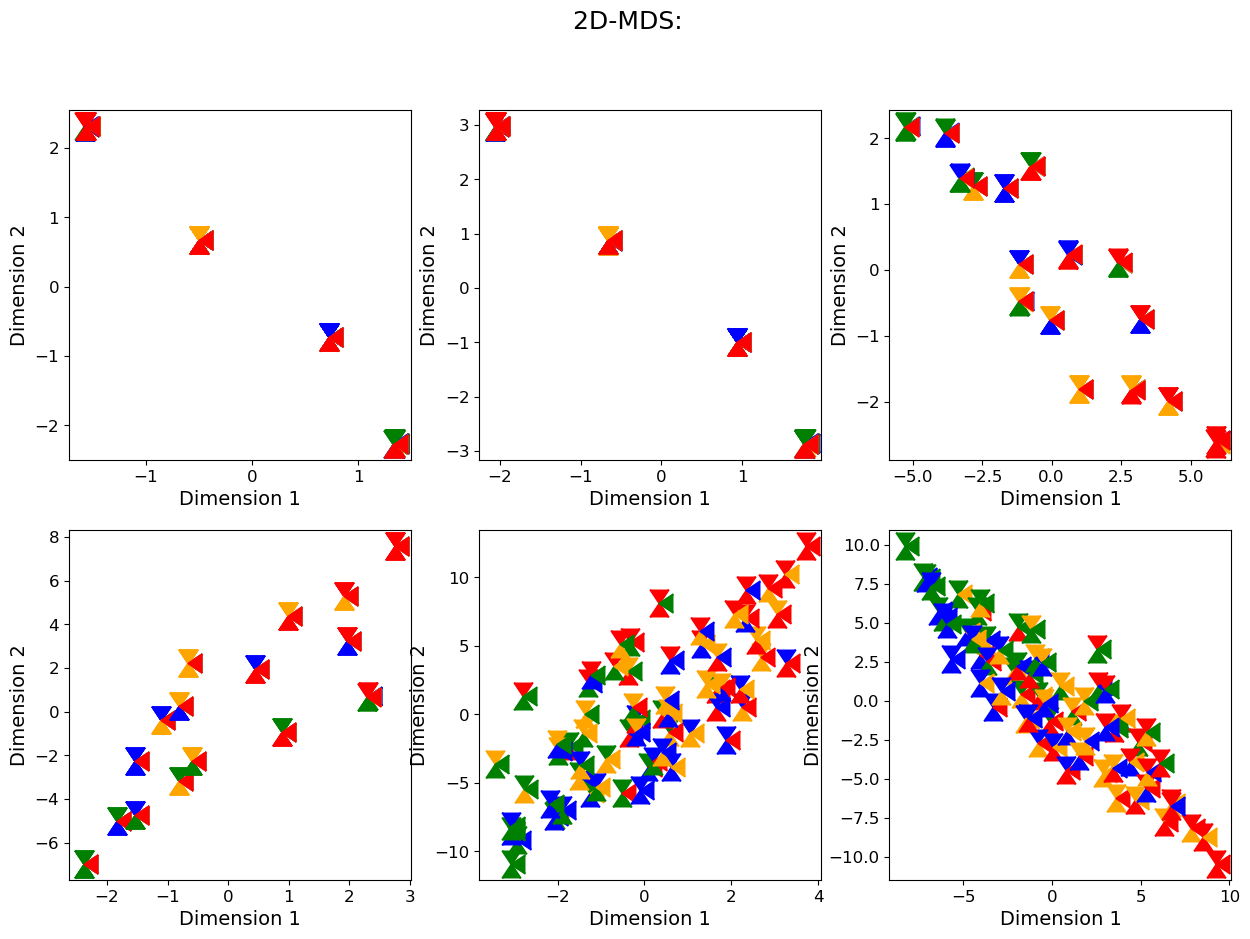

In [17]:
plt.rcParams['figure.figsize'] = (15,10)
fig, ax = plt.subplots(2,3)
ax = ax.flatten()

for i in range(6):
    MDS_plot_single(ax[i], dps[i], testseqs)

In [18]:
dbs = []
for j in range(6):
    dbs.append(np.array(allrdms['rdms_b'][j]).mean(axis=0))

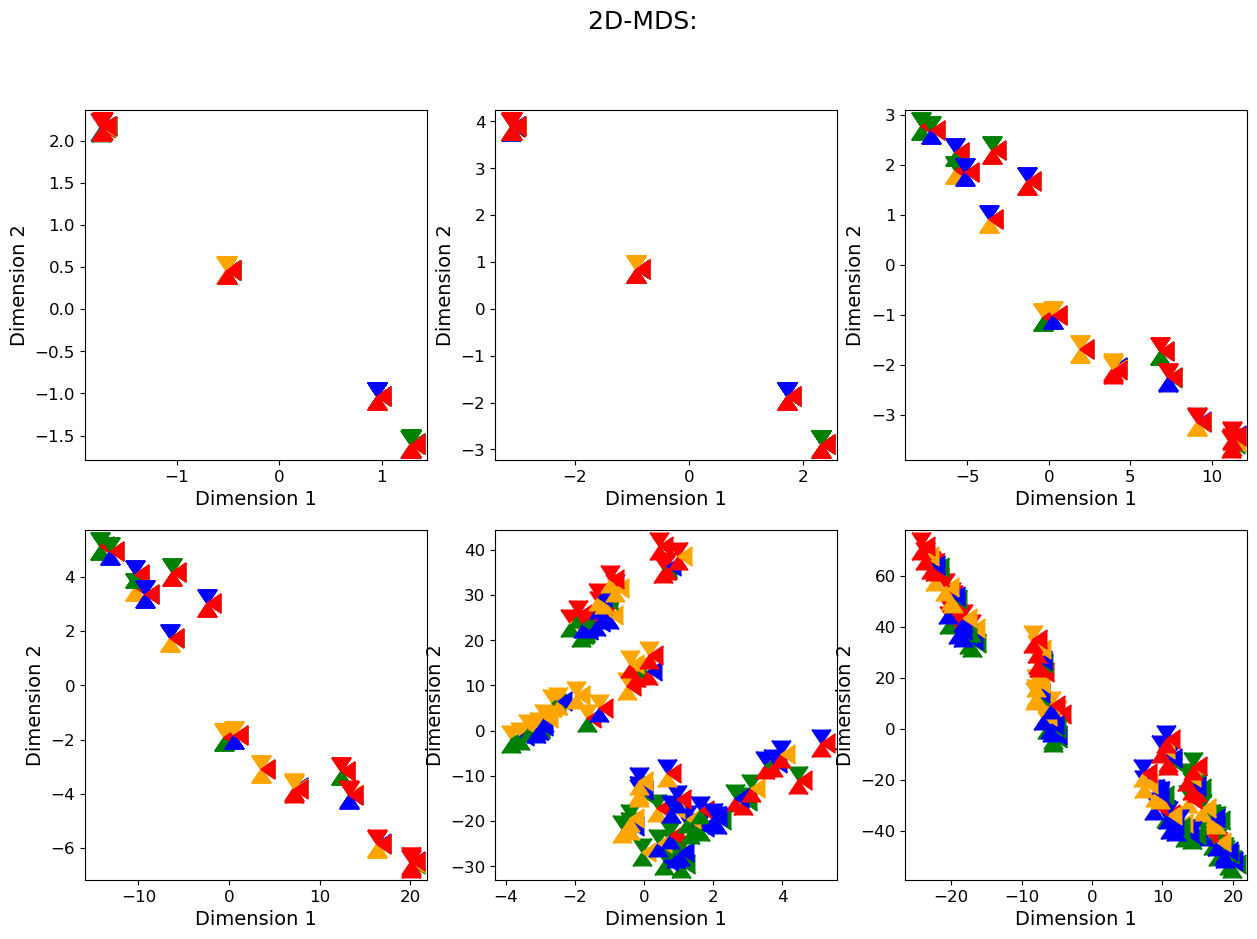

In [19]:
plt.rcParams['figure.figsize'] = (15,10)
fig, ax = plt.subplots(2,3)
ax = ax.flatten()

for i in range(6):
    MDS_plot_single(ax[i], dbs[i], testseqs)

## 3 steps

In [22]:
Tmax = 2*len(testseqs3[0][:-1])-1-1
allrdms3 = calculate_RDMs(res1, testseqs3, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

In [ ]:
dps3 = []
for j in range(6):
    dps3.append(np.array(allrdms3['rdms_p'][j]).mean(axis=0))

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
fig, ax = plt.subplots(2,3)
ax = ax.flatten()

for i in range(6):
    MDS_plot_single(ax[i], dps[i], testseqs)

## Accuracy

In [15]:
colors1 = ([ca]*16 + [cb]*16 + [cc]*16 + [ cd]*16)*2
colors2 = ([ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4)*8
colors3 = [ca, cb, cc, cd]*32

In [16]:
def MDS_plot_single(ax, meanRDM, testseqs, MDStype = 'MDS', title = '', plotlines=True, rand_state=0, min_dim=0):

    if MDStype == 'PCA':
        mds = PCA(n_components=3)
    if MDStype == 'MDS':
        mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

    X_transform = mds.fit_transform(meanRDM)
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=7, color = colors1[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=6, color = colors2[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=4, color = colors3[i], s=180)
        
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.suptitle('2D-'+MDStype+': '+title)
   

In [14]:
ca, cb, cc, cd = 'green', 'blue', 'orange', 'red'
colors1 = [ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4 + ['black']*4
colors2 = [ca, cb, cc, cd]*4 + [ca, cb, cc, cd]

msize = 12
legend_elements = [Line2D([0], [0], marker=6, color='w', markerfacecolor =ca, markersize=msize, label=' + A _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cb, markersize=msize, label=' + B _'), 
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cc, markersize=msize, label=' + C _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cd, markersize=msize, label=' + D _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=ca, markersize=msize, label=' _ + A'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cb, markersize=msize, label=' _ + B'), 
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cc, markersize=msize, label=' _ + C'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cd, markersize=msize, label=' _ + D'),
                   Line2D([0], [0], marker='_', color='black', markersize=10, label='primitive')
                   ]


In [34]:
colors1 = ([ca]*16 + [cb]*16 + [cc]*16 + [ cd]*16)*2
colors2 = ([ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4)*8
colors3 = [ca, cb, cc, cd]*32

In [35]:
len(colors2)

128

In [36]:
128/4

32.0

In [139]:
def test_loss(model, testdata, criterion, hidden_size=20):
    model.eval()
    losses_testset = []
    
    for testset in testdata:
        loss_set = 0
        
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                loss_set += criterion(y_hat,y[i]).item()
     
        losses_testset.append(loss_set)
        
    return losses_testset

In [107]:
criterion = nn.MSELoss()

In [140]:
i = random.randint(0,200)

model = res1['mods_b'][i]
cuedict = res1['cue_dicts'][i]
 
testseqs = change_dict(testseqs, cuedict)
test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
testdata = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)


test_loss(model, [testdata, testdata], criterion)

[1021569.3879394531, 1021569.3879394531]

In [100]:
res1.keys()

dict_keys(['mods', 'mods_b', 'mods_p', 'mods_bp', 'res', 'tests', 'cue_dicts', 'acc_df'])

In [138]:
for i, j in enumerate([3,6,7,8]):
    print(i)

0
1
2
3
